In [1]:
import os
import sys
sys.path.append("./..")
from utils import PROJECT_ROOT, process_Danenberg_clinical_data, process_Jackson_clinical_data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import networkx as nx
from matplotlib.lines import Line2D
import pandas as pd
from c_Population_graph.population_graph import construct_PopulationGraph

# Parameters

In [2]:
iteration = 2
PhenoGraph_k =  200
node_label = 'CellType'
Pattern_ids = [6]

# Subset 1

### Clinical

In [3]:
clinical = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Input",
        "Clinical",
        "Danenberg",
        "clinical.csv",
    )
)
clinical.head()


,Unnamed: 0,metabric_id,patient_id,Cohort,Overall Survival (Months),Overall Survival Status,Relapse Free Status (Months),Relapse Free Status,Chemotherapy,Radio Therapy,...,ERStatus,ERBB2_pos,Grade,sizeOrdinal,LymphNodesOrdinal,PAM50,isDiscovery,IntClust,Clinical Subtype,Subset_id
0,1,MB-0002,2,1.0,84.633333,0.0,83.52,0.0,NO,YES,...,pos,False,3.0,5-10mm,0,Luminal A,True,IntClust 4+,HR+/HER2-,2
1,2,MB-0005,5,1.0,163.700000,1.0,151.28,1.0,YES,NO,...,pos,False,2.0,10-20mm,1,Luminal B,True,IntClust 3,HR+/HER2-,2
2,3,MB-0006,6,1.0,164.933333,0.0,162.76,0.0,YES,YES,...,pos,False,2.0,20-50mm,2-3,Luminal B,True,IntClust 9,HR+/HER2-,1
3,5,MB-0010,10,1.0,7.800000,1.0,2.89,1.0,NO,YES,...,pos,False,3.0,20-50mm,0,Luminal B,True,IntClust 7,HR+/HER2-,1
4,6,MB-0014,14,1.0,164.333333,0.0,162.17,0.0,YES,YES,...,pos,False,2.0,5-10mm,1,Luminal B,True,IntClust 3,HR+/HER2-,1


### Histogram

In [4]:
SoftWL_dict = pickle.load(
    open(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Danenberg",
            "Subset_1",
            "SoftWL_dict_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            +'_'
            +str(node_label)
            + ".pkl",
        ),
        "rb",
    ),
)

Histograms = SoftWL_dict["Histogram"]
Patient_IDs = SoftWL_dict["Patient_id"]
Histograms = Histograms/np.sum(Histograms,axis=1, keepdims=True)

### Presentation in 3 grade

Metastasis:  [ 8. nan  0.  0.  7.  3. nan  0.  1.  7.  3. 15. 41.  1. nan  3.  0.  1.
  0.  0.  0.  0.  1.  1.  2.  0.  4.  2.  1. nan  0.  6.  0.  0. 24. nan
 nan  3. 25.  1.  0.  8.  5.  2. nan nan  0.  0.  6. nan nan  0.  0.  1.
  1.  0.  1.  2.  1. 16.  2.  1. 15.  0. 12.  1.  0. 10.  9. nan  1. nan
  6.  3.  0.  5.  1.  0.  6.  4.  1.  0.  4.  6.  0. 10.  0.  0. 21.  7.
  0.  1.  0. 14.  0.  0.  1. 26.  2.  1.  0.  0.  0.  1.  2.  1.  2.  0.
  0.  1.  0.  1.  6.  0.  4.  7.  1.  0.  0.  1. 18.  1.  1.  0.  2.  8.
  5. nan nan nan  0.  3.  0. nan  1.  0.  2.  0.  6.  0.  0.  0.  0. nan
  0.  3.  7.  1.  0.  2.  6.  6. nan  0.  2. 11.  4. nan 17.  0.  0.  0.
  0. 12.  0.  8.  0. nan nan  0.  0.  0.  6.  6.  8.  0. nan  0.  0.  5.
  0.  0.  0. nan  1. nan  0.  1.  0.  0. nan  3.  1.  0. nan  0.  0.  0.
  4.  3.]
[False False  True  True False False False  True False False False False
 False False False False  True False  True  True  True  True False False
 False  True False False Fal

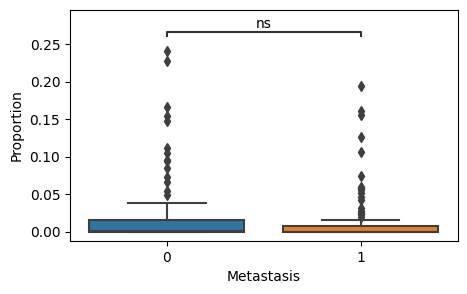

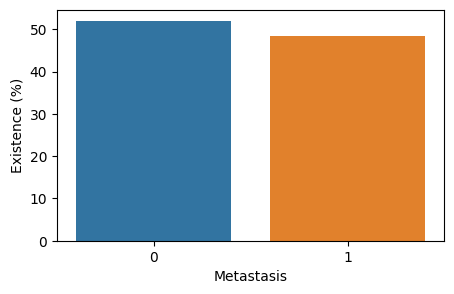

In [19]:

Metastasis = np.array([clinical.loc[clinical["patient_id"] == patient_id, "Lymph nodes examined positive"].values[0]
        for patient_id in Patient_IDs])
Metastasis[Metastasis>0] = 1

for pattern_id in Pattern_ids:
    histogram = Histograms[:, pattern_id - 1]
    DF_presentation = pd.DataFrame(
        {
            "Proportion": histogram,
            "Metastasis": Metastasis,
        }
    )
    DF_presentation = DF_presentation.dropna()
    f, ax = plt.subplots(figsize=(5, 3))
    sns.boxplot(
        x="Metastasis",
        y="Proportion",
        data=DF_presentation,
        showfliers=True,
        order = [0,1]
        # order=["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC"],
    )
    from statannotations.Annotator import Annotator
    annot = Annotator(
        ax,
        [(0,1)],
        data=DF_presentation,
        x="Metastasis",
        y="Proportion",
        order = [0,1]
    )
    annot.configure(test="Mann-Whitney", text_format="star", loc="inside", verbose=2, )
    annot.apply_test()
    ax, test_results = annot.annotate()

    DF_existence = pd.DataFrame(
        {
            "Metastasis": [0,1],
        }
    )
    for metastasis in [0,1]:
        data = DF_presentation.loc[
            DF_presentation["Metastasis"] == metastasis, "Proportion"
        ].values

        exisitence_ratio = np.sum(data > 0) / len(data)
        DF_existence.loc[
            DF_existence["Metastasis"] == metastasis, "Existence (%)"
        ] = (exisitence_ratio * 100)
        print(
            "Pattern {} in {} has {:.0f}% of patients".format(
                pattern_id, metastasis, exisitence_ratio * 100
            )
        )
    f, ax = plt.subplots(figsize=(5, 3))
    sns.barplot(
        x="Metastasis",
        y="Existence (%)",
        data=DF_existence,
        order=[0,1],
    )

# Subset 2

### Clinical

In [20]:
clinical = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Input",
        "Clinical",
        "Danenberg",
        "clinical.csv",
    )
)
clinical.head()


,Unnamed: 0,metabric_id,patient_id,Cohort,Overall Survival (Months),Overall Survival Status,Relapse Free Status (Months),Relapse Free Status,Chemotherapy,Radio Therapy,...,ERStatus,ERBB2_pos,Grade,sizeOrdinal,LymphNodesOrdinal,PAM50,isDiscovery,IntClust,Clinical Subtype,Subset_id
0,1,MB-0002,2,1.0,84.633333,0.0,83.52,0.0,NO,YES,...,pos,False,3.0,5-10mm,0,Luminal A,True,IntClust 4+,HR+/HER2-,2
1,2,MB-0005,5,1.0,163.700000,1.0,151.28,1.0,YES,NO,...,pos,False,2.0,10-20mm,1,Luminal B,True,IntClust 3,HR+/HER2-,2
2,3,MB-0006,6,1.0,164.933333,0.0,162.76,0.0,YES,YES,...,pos,False,2.0,20-50mm,2-3,Luminal B,True,IntClust 9,HR+/HER2-,1
3,5,MB-0010,10,1.0,7.800000,1.0,2.89,1.0,NO,YES,...,pos,False,3.0,20-50mm,0,Luminal B,True,IntClust 7,HR+/HER2-,1
4,6,MB-0014,14,1.0,164.333333,0.0,162.17,0.0,YES,YES,...,pos,False,2.0,5-10mm,1,Luminal B,True,IntClust 3,HR+/HER2-,1


### Histograms

In [21]:
SoftWL_dict = pickle.load(
    open(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Danenberg",
            "Subset_2",
            "Matched_SoftWL_dict_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            +'_'
            +str(node_label)
            + "_centroid_alignment.pkl",
        ),
        "rb",
    ),
)

Histograms = SoftWL_dict["Histogram"]
Patient_IDs = SoftWL_dict["Patient_id"]
Histograms = Histograms/np.sum(Histograms,axis=1, keepdims=True)

### Presentation in 4 clinical subtypes

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:3.044e-01 U_stat=4.002e+03
Pattern 6 in 0 has 52% of patients
Pattern 6 in 1 has 49% of patients


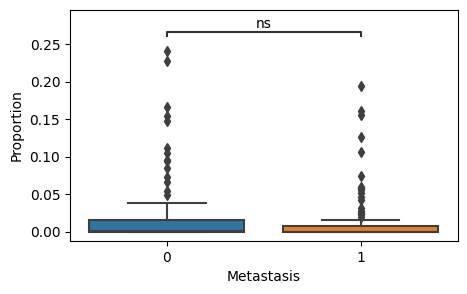

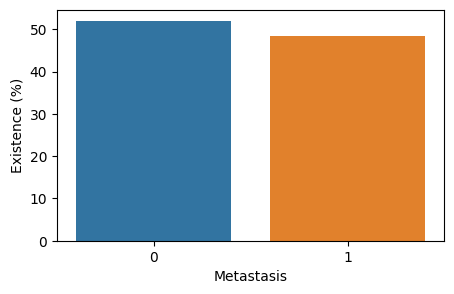

In [22]:

Metastasis = np.array([clinical.loc[clinical["patient_id"] == patient_id, "Lymph nodes examined positive"].values[0]
        for patient_id in Patient_IDs])
Metastasis[Metastasis>0] = 1

for pattern_id in Pattern_ids:
    histogram = Histograms[:, pattern_id - 1]
    DF_presentation = pd.DataFrame(
        {
            "Proportion": histogram,
            "Metastasis": Metastasis,
        }
    )
    DF_presentation = DF_presentation.dropna()
    f, ax = plt.subplots(figsize=(5, 3))
    sns.boxplot(
        x="Metastasis",
        y="Proportion",
        data=DF_presentation,
        showfliers=True,
        order = [0,1]
        # order=["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC"],
    )
    from statannotations.Annotator import Annotator
    annot = Annotator(
        ax,
        [(0,1)],
        data=DF_presentation,
        x="Metastasis",
        y="Proportion",
        order = [0,1]
    )
    annot.configure(test="Mann-Whitney", text_format="star", loc="inside", verbose=2, )
    annot.apply_test()
    ax, test_results = annot.annotate()

    DF_existence = pd.DataFrame(
        {
            "Metastasis": [0,1],
        }
    )
    for metastasis in [0,1]:
        data = DF_presentation.loc[
            DF_presentation["Metastasis"] == metastasis, "Proportion"
        ].values

        exisitence_ratio = np.sum(data > 0) / len(data)
        DF_existence.loc[
            DF_existence["Metastasis"] == metastasis, "Existence (%)"
        ] = (exisitence_ratio * 100)
        print(
            "Pattern {} in {} has {:.0f}% of patients".format(
                pattern_id, metastasis, exisitence_ratio * 100
            )
        )
    f, ax = plt.subplots(figsize=(5, 3))
    sns.barplot(
        x="Metastasis",
        y="Existence (%)",
        data=DF_existence,
        order=[0,1],
    )

# Jackson

### Clinical

In [23]:
clinical = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Input",
        "Clinical",
        "Jackson",
        "clinical.csv",
    )
)
clinical = process_Jackson_clinical_data(clinical)
clinical.head()


,Unnamed: 0,patient_id,Relapse Free Status (Months),Relapse Free Status,Overall Survival (Months),Overall Survival Status,Grade,tumor_size,Age,PTNM_T,...,Post-surgeryTx,response,Subtype,clinical_type,Relapse-free Status (Months),Clinical Subtype,HR+/HER2-,HR+/HER2+,HR-/HER2+,TNBC
0,0,1,0.0,1:Recurred,33.0,1,2,35,83,2,...,Hormone therapy,Refractory,PR+ER+,HR+HER2-,NaN,HR+/HER2-,1.0,0.0,0.0,0.0
1,1,2,101.0,1:Recurred,101.0,0,2,15,40,1c,...,Chemotherapy - Tamoxifen,NaN,PR+ER+,HR+HER2-,NaN,HR+/HER2-,1.0,0.0,0.0,0.0
2,2,3,23.0,1:Recurred,23.0,1,3,75,63,3,...,Chemotherapy - Hormone therapy,Refractory,PR+ER+,HR+HER2-,NaN,HR+/HER2-,1.0,0.0,0.0,0.0
3,3,4,63.0,1:Recurred,63.0,0,1,11,49,1c,...,Tamoxifen,Sensitive,PR+ER+,HR+HER2-,NaN,HR+/HER2-,1.0,0.0,0.0,0.0
4,5,5,79.0,1:Recurred,79.0,0,2,19,49,1c,...,Tamoxifen,Sensitive,PR+ER+,HR+HER2-,NaN,HR+/HER2-,1.0,0.0,0.0,0.0


In [42]:
clinical['Post-surgeryTx'].value_counts()

Tamoxifen                                     94
Chemotherapy                                  34
Chemotherapy - Tamoxifen                      25
Hormone therapy                               20
Anastrazol                                    19
none                                          17
Chemotherapy - Hormone therapy                 7
Letrozol                                       7
Chemotherapy - Letrozol                        7
Chemotherapy - Anastrazol                      6
Chemotherapy - Immune therapy                  6
Immune therapy                                 6
Immune therapy - Anastrozol                    1
Chemotherapy - Immune therapy - Tamoxifen      1
Tamoxifen - Femara                             1
Exemestan                                      1
Chemotherapy - Immune therapy - Anastrozol     1
Name: Post-surgeryTx, dtype: int64

### Histogram

In [93]:
SoftWL_dict = pickle.load(
    open(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Jackson",
            "Matched_SoftWL_dict_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            +'_'
            +str(node_label)
            + "_centroid_alignment.pkl",
        ),
        "rb",
    ),
)

Histograms = SoftWL_dict["Histogram"]
Patient_IDs = SoftWL_dict["Patient_id"]
Histograms = Histograms/np.sum(Histograms,axis=1, keepdims=True)

['nan' 'Refractory' 'nan' 'Sensitive' 'nan' 'nan' 'nan' 'Sensitive'
 'Refractory' 'nan' 'Refractory' 'nan' 'nan' 'nan' 'Sensitive' 'nan' 'nan'
 'nan' 'Sensitive' 'Sensitive' 'Refractory' 'nan' 'Sensitive' 'nan'
 'Sensitive' 'Sensitive' 'Sensitive' 'Sensitive' 'nan' 'Resistant'
 'Resistant' 'nan' 'nan' 'Resistant' 'nan' 'nan' 'Resistant' 'Refractory'
 'Sensitive' 'nan' 'nan' 'Resistant' 'Resistant' 'nan' 'nan' 'Sensitive'
 'Resistant' 'Refractory' 'Refractory' 'Sensitive' 'Refractory'
 'Resistant' 'Sensitive' 'Sensitive' 'Sensitive' 'Sensitive' 'nan' 'nan'
 'nan' 'Sensitive' 'Sensitive' 'nan' 'Sensitive' 'nan' 'nan' 'Sensitive'
 'nan' 'Refractory' 'nan' 'Sensitive' 'Resistant' 'nan' 'Sensitive'
 'Resistant' 'nan' 'Sensitive' 'Sensitive' 'Sensitive' 'Sensitive'
 'Sensitive' 'Refractory' 'nan' 'Resistant' 'Sensitive' 'nan' 'Refractory'
 'Refractory' 'Sensitive' 'Sensitive' 'Sensitive' 'nan' 'nan' 'nan' 'nan'
 'Sensitive' 'Sensitive' 'Refractory' 'Sensitive' 'nan' 'Refractory' 'nan'
 'nan'

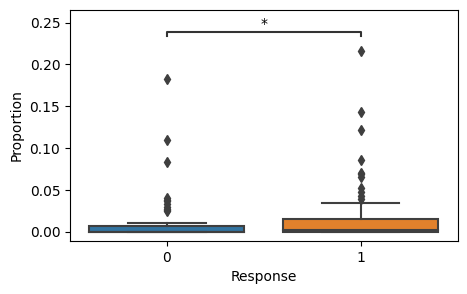

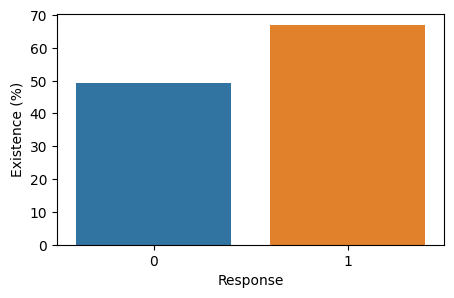

In [94]:
# Indices = (clinical['Post-surgeryTx']=='Chemotherapy').values
# Histograms = Histograms[Indices,:]
# Patient_IDs = np.array(Patient_IDs)[Indices]
Response = np.array([clinical.loc[clinical["patient_id"] == patient_id, "response"].values[0]
        for patient_id in Patient_IDs])
print(Response)
Response[Response == 'Sensitive'] = '1'
Response[Response == 'Resistant'] = '0'
Response[Response == 'Refractory'] = '0'
# Response = Response.astype(int)

# Metastasis[Metastasis>0] = 1

for pattern_id in Pattern_ids:
    histogram = Histograms[:, pattern_id - 1]
    DF_presentation = pd.DataFrame(
        {
            "Proportion": histogram,
            "Response": Response,
        }
    )
    DF_presentation = DF_presentation.dropna()

    DF_presentation = DF_presentation.dropna()
    f, ax = plt.subplots(figsize=(5, 3))
    sns.boxplot(
        x="Response",
        y="Proportion",
        data=DF_presentation,
        showfliers=True,
        order = ['0','1']
        # order=["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC"],
    )
    from statannotations.Annotator import Annotator
    annot = Annotator(
        ax,
        [('0','1')],
        data=DF_presentation,
        x="Response",
        y="Proportion",
        order = ['0','1']
    )
    annot.configure(test="Mann-Whitney", text_format="star", loc="inside", verbose=2, )
    annot.apply_test()
    ax, test_results = annot.annotate()

    DF_existence = pd.DataFrame(
        {
            "Response": ['0','1'],
        }
    )
    for metastasis in ['0','1']:
        data = DF_presentation.loc[
            DF_presentation["Response"] == metastasis, "Proportion"
        ].values

        exisitence_ratio = np.sum(data > 0) / len(data)
        DF_existence.loc[
            DF_existence["Response"] == metastasis, "Existence (%)"
        ] = (exisitence_ratio * 100)
        print(
            "Pattern {} in {} has {:.0f}% of patients".format(
                pattern_id, metastasis, exisitence_ratio * 100
            )
        )
    f, ax = plt.subplots(figsize=(5, 3))
    sns.barplot(
        x="Response",
        y="Existence (%)",
        data=DF_existence,
        order=['0','1'],
    )

### Presentation in 3 Grades

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:3.722e-01 U_stat=4.627e+03
Pattern 6 in 0 has 52% of patients
Pattern 6 in 1 has 45% of patients


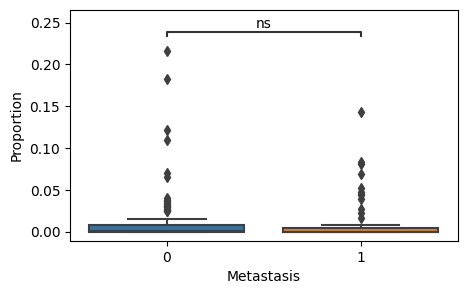

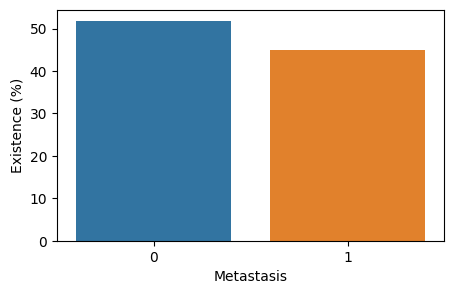

In [26]:

Metastasis = np.array([clinical.loc[clinical["patient_id"] == patient_id, "Lymphaticinvasion"].values[0]
        for patient_id in Patient_IDs])
Metastasis[Metastasis>0] = 1

for pattern_id in Pattern_ids:
    histogram = Histograms[:, pattern_id - 1]
    DF_presentation = pd.DataFrame(
        {
            "Proportion": histogram,
            "Metastasis": Metastasis,
        }
    )
    DF_presentation = DF_presentation.dropna()
    f, ax = plt.subplots(figsize=(5, 3))
    sns.boxplot(
        x="Metastasis",
        y="Proportion",
        data=DF_presentation,
        showfliers=True,
        order = ['0',1]
        # order=["HR+/'HER2'-", "HR+/HER2+", "HR-/HER2+", "TNBC"],
    )
    from statannotations.Annotator import Annotator
    annot = Annotator(
        ax,
        [(0,1)],
        data=DF_presentation,
        x="Metastasis",
        y="Proportion",
        order = [0,1]
    )
    annot.configure(test="Mann-Whitney", text_format="star", loc="inside", verbose=2, )
    annot.apply_test()
    ax, test_results = annot.annotate()

    DF_existence = pd.DataFrame(
        {
            "Metastasis": [0,1],
        }
    )
    for metastasis in [0,1]:
        data = DF_presentation.loc[
            DF_presentation["Metastasis"] == metastasis, "Proportion"
        ].values

        exisitence_ratio = np.sum(data > 0) / len(data)
        DF_existence.loc[
            DF_existence["Metastasis"] == metastasis, "Existence (%)"
        ] = (exisitence_ratio * 100)
        print(
            "Pattern {} in {} has {:.0f}% of patients".format(
                pattern_id, metastasis, exisitence_ratio * 100
            )
        )
    f, ax = plt.subplots(figsize=(5, 3))
    sns.barplot(
        x="Metastasis",
        y="Existence (%)",
        data=DF_existence,
        order=[0,1],
    )

### K-M Plot

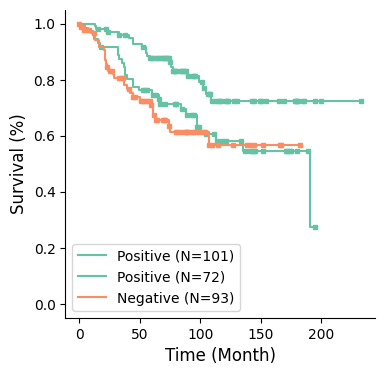

In [23]:
color_palette = sns.color_palette("Set2")
Length = np.array(
    [
        clinical.loc[clinical["patient_id"] == i, "Overall Survival (Months)"].values[0]
        for i in Patient_IDs
    ]
)
Status = np.array(
    [
        clinical.loc[clinical["patient_id"] == i, "Overall Survival Status"].values[0]
        for i in Patient_IDs
    ]
)

from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test, logrank_test

kmf = KaplanMeierFitter()
clinical_subtype="HR+/HER2-"
f, ax = plt.subplots(figsize=(4, 4))
histogram = Histograms[:, Pattern_ids[0] - 1]
length_A, event_observed_A = (
        Length[
            (Clinical_subtype == clinical_subtype)
            & (histogram > 0)
        ],
        Status[
            (Clinical_subtype == clinical_subtype)
            & (histogram > 0)
        ],
    )
label = "Positive (N={})".format(len(length_A))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(
        ax=ax,
        ci_show=False,
        color=color_palette[0],
        show_censors=True,
        censor_styles={"ms": 3, "marker": "s"},
    )

histogram = Histograms[:, Pattern_ids[0] - 1]
length_A, event_observed_A = (
        Length[
            (Clinical_subtype == clinical_subtype)
            & (histogram == 0)
        ],
        Status[
            (Clinical_subtype == clinical_subtype)
            & (histogram == 0)
        ],
    )
label = "Positive (N={})".format(len(length_A))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(
        ax=ax,
        ci_show=False,
        color=color_palette[0],
        show_censors=True,
        censor_styles={"ms": 3, "marker": "s"},
    )



length_B, event_observed_B = (
        Length[
            (Clinical_subtype != clinical_subtype)
      
        ],
        Status[
            (Clinical_subtype != clinical_subtype)

        ],
    )
label = "Negative (N={})".format(len(length_B))
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(
        ax=ax,
        ci_show=False,
        color=color_palette[1],
        show_censors=True,
        censor_styles={"ms": 3, "marker": "s"},
    )
    # log_rank_test = multivariate_logrank_test(
    #     np.concatenate([length_A, length_B]),
    #     [0] * len(length_A) + [1] * len(length_B),
    #     np.concatenate([event_observed_A, event_observed_B]),
    # )
    # p_value = log_rank_test.p_value
    # ax.legend(fontsize=10)
    # ax.set_title("{} (p-value = {:.5f})".format(clinical_subtype, p_value), fontsize=12)
ax.set_xlabel("Time (Month)", fontsize=12)
ax.set_ylabel("Survival (%)", fontsize=12)
ax.set(
        ylim=(-0.05, 1.05),
    )
sns.despine()